Importing the necessary libraries

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

Initialize the learning rate, number of epochs and batch size

In [2]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

Grab the list of images in the dataset and then initialize the list of images and class of images

In [3]:
DIRECTORY = r"C:\Users\A V NITHYA\Desktop\FACEMASK\dataset"
CATEGORIES = ["with_mask", "without_mask"]
print("loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

loading images...


C:\Users\anaconda\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Assign unique values to each label

In [4]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

Split the data into training and test sets (80% for training and 20% for testing) 

In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

Construct the training image generator for data augmentation

In [6]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

Load the MobileNetV2 network, ensuring the fully-connected head layer sets are left off

In [7]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))


Construct the head of the model that will be placed on top of the base model

In [8]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

Place the head FC model on top of the base model 

In [9]:
model = Model(inputs=baseModel.input, outputs=headModel)

Loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [10]:
for layer in baseModel.layers:
	layer.trainable = False

Compile the model

In [11]:
print("Compilation of the MODEL is going on...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

Compilation of the MODEL is going on...


C:\Users\anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train the head of the network

In [12]:
print("Training of the Head Started...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Training of the Head Started...
Epoch 1/10
95/95 [==============================] - 79s 782ms/step - loss: 0.4131 - accuracy: 0.8309 - val_loss: 0.1418 - val_accuracy: 0.9857
Epoch 2/10
95/95 [==============================] - 72s 757ms/step - loss: 0.1529 - accuracy: 0.9588 - val_loss: 0.0720 - val_accuracy: 0.9896
Epoch 3/10
95/95 [==============================] - 74s 773ms/step - loss: 0.0938 - accuracy: 0.9759 - val_loss: 0.0633 - val_accuracy: 0.9817
Epoch 4/10
95/95 [==============================] - 73s 770ms/step - loss: 0.0851 - accuracy: 0.9769 - val_loss: 0.0435 - val_accuracy: 0.9909
Epoch 5/10
95/95 [==============================] - 74s 782ms/step - loss: 0.0764 - accuracy: 0.9773 - val_loss: 0.0383 - val_accuracy: 0.9909
Epoch 6/10
95/95 [==============================] - 78s 820ms/step - loss: 0.0585 - accuracy: 0.9829 - val_loss: 0.0355 - val_accuracy: 0.9909
Epoch 7/10
95/95 [==============================] - 78s 819ms/step - loss: 0.0526 - accuracy: 0.9835 - val_los

 Make predictions on the testing set

In [13]:
print("Network evaluation...")
preds = model.predict(testX, batch_size=BS)

Network evaluation...


For each image in the testing set, find the index of the label with corresponding largest predicted probability

In [14]:
preds = np.argmax(preds, axis=1)

Print the classification report

In [15]:
print(classification_report(testY.argmax(axis=1), preds,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



Serialize the model to disk 

In [16]:
print("saving mask model...")
model.save("mask_detector.model", save_format="h5")

saving mask model...


Plot the training loss and accuracy

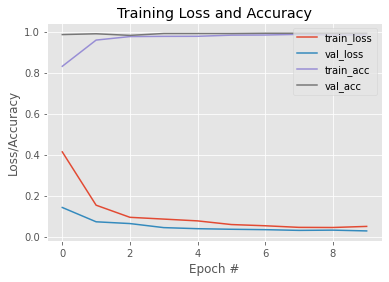

In [17]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
